<a href="https://colab.research.google.com/github/meixinzhang/rigid-moving-objects/blob/main/rigid-moving-object.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Detection and Segmentation of Rigidly Moving Objects

By Meixin Zhang, Yufeng Li

### *Abstract*

So far in the course, all of our segmentation work had been done with some weak supervision (eg. seeds provided by user input). However, with two pictures that contain objects going through different motions, we may use epipolar geometry to find feature points from the images that are fitted to different essential matrices. This gives us a means to classify some points from the images. Given these feature points undergoing different motions, we can apply semi-supervised techniques for segmentation. As there has been no user input in this process, we can detect and perform segmentation on moving objects in images without any supervision.

In this project, our approach is that we will first use a UFL-based algorithm covered in class to detect multiple essential matrix-based models that ideally should classify feature points for different moving objects into different classes. This step allows us to assign detected feature points to classes and gives us some seeds that are required for segmentation without any user supervision. After the feature points have been assigned a class, we use graph cut to perform segmentation of the moving objects based on the labeled feature points in the first step. We will use graph cut iteratively for each class given by the UFL algorithm by setting points belonging to one class as the sink nodes and points from all other classes as source nodes. We repeat this process for each class until all inlier points have been used for segmentation. The result should give us a mask for different moving objects in the image.


### Team Members and Contributions

- Meixin: Meixin was responsible for finding appropriate images for the project, implementing feature detection and matching functions (functions in `mylibs/structure_from_motion_lib`) as well as the graph-cut module in `mylibs/my_graph_cut.py` and segmentation implementation. Meixin also helped debug some of the UFL implementations and was responsible for the majority of the write-up and cleaning and structuring of the code of this project.

- Yufeng: Yufeng helped with finding images and the camera calibration parameters for the project. Yufeng was responsible for the majority of the UFL implementation in `mylibs/ufl` and feature classification implementation. Yufeng also wrote the section explaining the UFL implementation, tuned the parameters of UFL, and explained why the UFL implementation was not as effective as expected.


### Code Libraries

The essential libraries for this project are as follows:

- numpy, numpy.linalg are used for array and image manipulation
- matplotlib.image is used when reading the images for processing
- matplotlib.pyplot is used for plotting the graphical results throughout the project
- matplotlib.colors.from_levels_and_colors, matplotlib.colors.colorConverter, matplotlib.colors.cnames are used to manipulate colours when presenting the segmentation mask on the images
- skimage.feature.plot_matches is used for plotting the feature matches found by BRIEF descriptor
- skimage.color.rgb2gray is used to create gray images as they are needed for feature detection and matching

(Used in `structure_from_motion_lib`)
- skimage.feature.corner_harris, skimage.feature.corner_peaks are used to detect feature points in images
- skimage.feature.BRIEF, skimage.feature.match_descriptors are used to match detected feature points in the two images

(Used in `ufl`)
- skimage.transform.EssentialMatrixTransform is the model used to fit different points in UFL

(Used in `my_graph_cut`)
- maxflow is used to implement graph cut, specifically, it was used to find the optimal cut
- sklearn.mixture is used to find the likelihood of a colour belonging to a class

In [1]:
# Packages
import numpy as np
import matplotlib as mpl
import matplotlib.image as image
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter, cnames, from_levels_and_colors
from skimage.feature import plot_matches

from skimage.color import rgb2gray

# Our Libraries 
from mylibs.structure_from_motion_lib import (
    get_matched_keyppoints, 
    matchedpoints_to_pairpoints, 
    camera_calib_nomalization,
    estimate_ufl
)
from mylibs.ufl import UFL

from mylibs.my_graph_cut import MaskBuilder, MyGraphCuts

## Implementation

First, we read in two images with multiple rigidly moving objects. (Source: KITTI-SF image_02 folder)

We have found that in the dataset documentation that the camera calibration of the images is 

$$
K = \begin{bmatrix}
9.597910 e^{02} & 0 & 6.960217 e^{02} \\
0 & 9.569251 e^{02} & 2.241806 e^{02} \\
0 & 0 & 1
\end{bmatrix}
$$

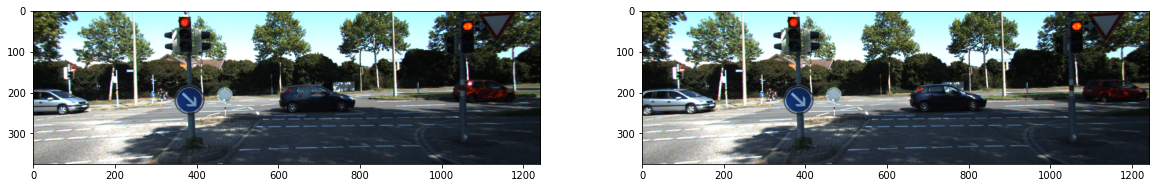

In [2]:
%matplotlib inline

# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)
imL = image.imread("images/car1_left.png")
imR = image.imread("images/car1_right.png")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

# using K_02 from calibration.txt
K = 1.0e+02 * np.array([[9.597910,        0, 6.960217],
                        [       0, 9.569251, 2.241806],
                        [       0,        0,    0.010]])

plt.figure(0,figsize = (20, 8))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()

### Structure from Motion Using UFL and Epipolar Geometry

##### Step 1: Feature Detection and Matching
Detect features on the given pictures using Harris corner detector and match the features on the two images using BRIEF descriptor.

the number of features in images 1 and 2 are   249 and   249
the number of matches is 199


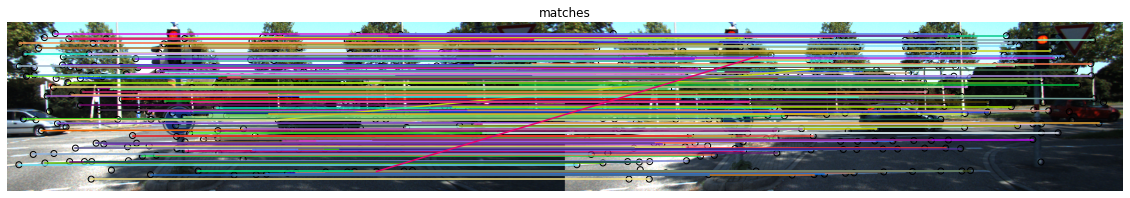

In [3]:
# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL, keypointsR, matchesLR = get_matched_keyppoints(imLgray, imRgray)

fig = plt.figure(2, figsize = (20, 8))
axA = plt.subplot(111)
axA.set_title("matches")
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

#### Step 2: Camera Normalization and Essential Matrix estimation using UFL

Recall that the normalization of the camera that tooke the two images is given by multiplying the points by $K^{-1}$, where $K$ is the calibration parameters of the camera.

In [4]:
ptsL_inv, ptsR_inv = matchedpoints_to_pairpoints(keypointsL, keypointsR, matchesLR)
# swapping columns using advanced indexing https://docs.scipy.org/doc/numpy/reference/arra
# This changes point coordinates from (y,x) in ptsL1/ptsR1 to (x,y) in ptsL/ptsR
ptsL, ptsR = ptsL_inv[:,[1, 0]], ptsR_inv[:,[1, 0]]

n_ptsL = camera_calib_nomalization(ptsL, K)
n_ptsR = camera_calib_nomalization(ptsR, K)

The UFL method of estimating multiple essential matrices we implemented is the method described in Lecture 6. The `UFL` class accepts parameters $K$, $\gamma$, and $T$ that correspond to the variables used in slides 65 to 69 of Lecture 6. The `estimate_ufl` method in `UFL` accepts as inputs an array of source points `src_pts` and destination points `dst_pts`, and  The lengths of the `src_pts` and `dst_pts` array must be the same.

Let $N$ be the length of the `src_pts` and `dst_pts` arrays. Then, `estimate_ufl` returns a pair `(result_models, pts_to_models)` where `result_models` is a list of homographies and `pts_to_models` is a list of length $N$ such that each `pts_to_models[i]` refers to an index in `result_models`. Together, `(result_models, pts_to_models)` describe a correspondence between the input `src_pts, dst_pts` and  homographies between various subsets of these points. The correspondence is described in the following manner:

  - If `pts_to_models[i] = -1` then the source point `src_pts[i]` and `dst_pts[i]` are outliers
  - Otherwise, `result_models[pts_to_models[i]]` is a homography that maps `src_pts[i]` to `dst_pts[i]`
 
Therefore, the `src_pts[k], dst_pts[k]` is an inlier the $i$-th model `result_models[i]` precisely when `pts_to_models[k] = i`.
 
The `estimate_ufl` function is implemented in the following steps:

  1. (implemented in `initialize_models`) Randomly choose $K$ subsets of size 8 to compute $K$ homographies (`EssentialMatrixTransform`) where each homography perfectly fits the corresponding 8 chosen points. 
  2. (implemented in `reestimate_models`) (a) Associate each `(src_pts[i], dst_pts[i])` to the nearest model in the currently maintained list of models. The points associated with each model are the inliers for that model. If a model was found to have no inliers, then this model is removed from the list of models.
     (b) Re-estimate each model using the inliers assigned in step (a). 
  3. (implemented in `remove_models`) Apply the UFL heuristic by removing the models whose costs of keeping are too high. The cost of a model $H$ is defined to be the sum of the distances of the inlier points to $H$ added to the base cost of keeping a model, $\gamma$. Here, if $(s,d) = $`(src_pts[i], dst_pts[i])` is an inlier of $H$ then its distance to $H$ is defined by $\lVert d - Hs \rVert$. On the other hand, we also compute the removal cost of $H$, which is the sum of the distances of its inliers to the next closest model suppose that $H$ is removed. If the removal cost is lower than the keeping cost, the model $H$ is removed.
  4. Iterate steps 2 and 3 until the energy of the system converges. Here, the energy of the system is defined as the sum of distances of each point to their respective model, with an additional cost $\gamma L$ where $L$ is the length of the current list of models. In the end, the algorithm applies step 2 again to ensure the parameters are optimal.

----------
inlier points index for model 0 is (array([ 19,  22,  35,  38,  48,  57,  61,  69,  78,  81,  86,  87, 131,
       143, 184, 186]),)
cost to keep model 0 is 288.59857629499317
cost to remove model 0 is 85.81437829831853
----------
inlier points index for model 1 is (array([ 11,  39,  60,  64, 118, 123, 146, 173, 187, 189, 193, 198]),)
cost to keep model 1 is 105.89029714894026
cost to remove model 1 is 58.61260051986821
----------
inlier points index for model 2 is (array([ 23,  28,  32,  98, 101, 116, 122, 125, 130, 134, 135, 140]),)
cost to keep model 2 is 195.4043173825587
cost to remove model 2 is 34.1531085924298
----------
inlier points index for model 3 is (array([  3,  33,  74,  77,  79,  80,  82,  88,  92,  93,  96,  99, 117,
       120, 136]),)
cost to keep model 3 is 107.99979391164636
cost to remove model 3 is 98.18239566989874
----------
inlier points index for model 4 is (array([  0,   1,  10,  12,  15,  17,  20,  21,  30,  47,  49,  56,  68,
        72,  84,  

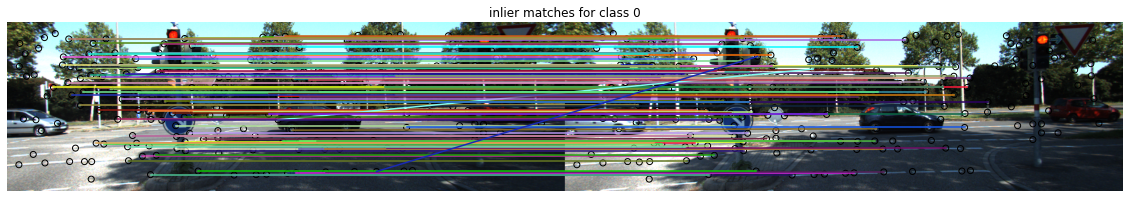

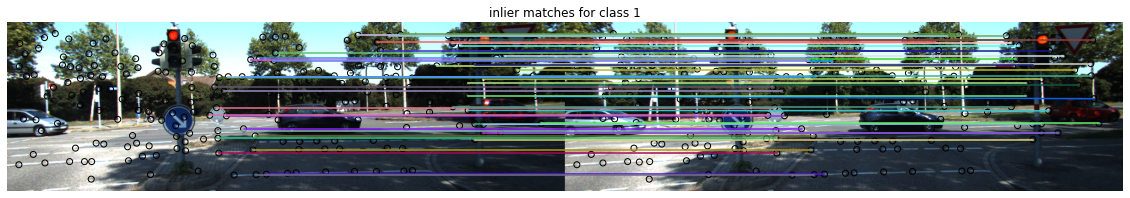

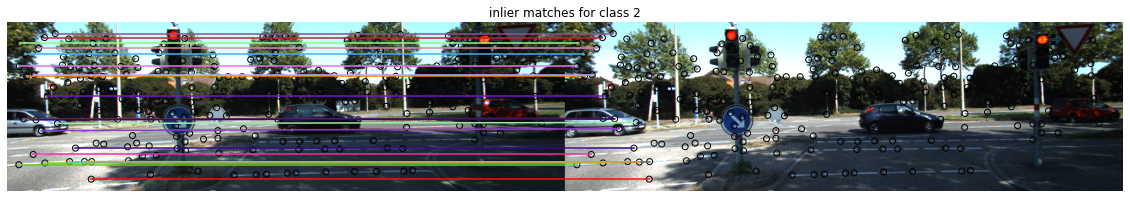

In [6]:
UFLEstimator = UFL(K=100, gamma=0.01, T=10)
E_ufl_trans, E_ufl_models = UFLEstimator.estimate_ufl(n_ptsL, n_ptsR)
num_inliers = len(np.where(E_ufl_models > -1)[0])
num_classes = int(len(np.unique(E_ufl_models[np.where(E_ufl_models > -1)])))
print ('the number of classes found by ufl is {:d}'.format(num_classes))
print ('the number of ufl inliers is {:d}'.format(num_inliers))

# Show the inliers for the different classes
for i in range(num_classes):
    E_i = E_ufl_trans[i]    # Singular values for E
    E_inliers_i = np.where(E_ufl_models == i)[0]

    ind = np.ogrid[:n_ptsL.shape[0]]
    EmatchesRansac = np.column_stack((ind[E_inliers_i],ind[E_inliers_i]))

    fig = plt.figure(5+i,figsize = (20, 8))
    axA = plt.subplot(111)
    axA.set_title(f"inlier matches for class {i}")
    plt.gray()
    # NOTE: function "plot matches" expects that keypoint coordinates are given as (y,x), that is (row, col)
    plot_matches(axA, imL, imR, ptsL_inv, ptsR_inv, EmatchesRansac)
    axA.axis('off')
    plt.show()

The resulting classified feature points are

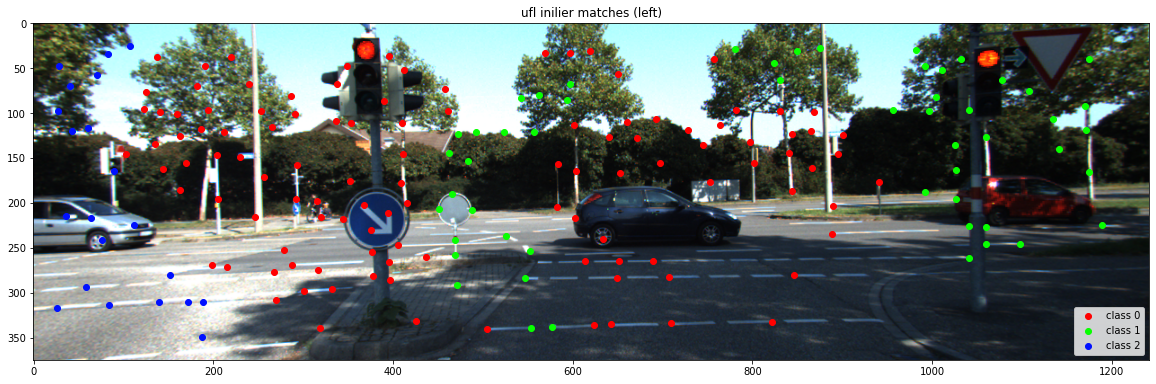

In [7]:
# Maps object points to colours
c_map = plt.cm.get_cmap('hsv', num_classes+1)

ufl_l_fig = plt.figure(12,figsize = (20, 8))
ufl_l_ax = plt.subplot(111)
ufl_l_ax.set_title("ufl inilier matches (left)")
ufl_l_ax.imshow(imL)

for i in range(num_classes):
    class_colour = c_map(i)
    class_pts = ptsL[np.where(E_ufl_models == i)]
    ufl_l_ax.scatter(x=class_pts[:,0], y=class_pts[:,1], color=class_colour, label=f'class {i}')
    
ufl_l_ax.legend()


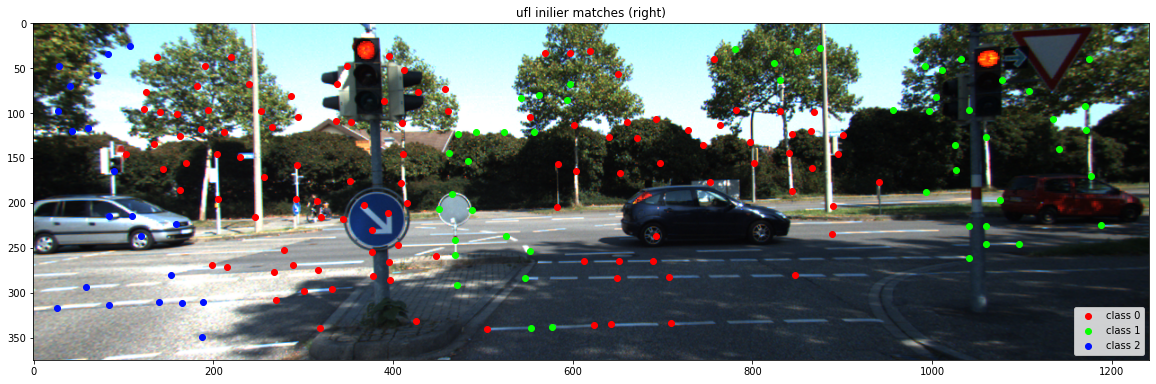

In [8]:
ufl_r_fig = plt.figure(13,figsize = (20, 8))
ufl_r_ax = plt.subplot(111)
ufl_r_ax.set_title("ufl inilier matches (right)")
ufl_r_ax.imshow(imR)

for i in range(num_classes):
    class_colour = c_map(i)
    class_pts = ptsR[np.where(E_ufl_models == i)]
    ufl_r_ax.scatter(x=class_pts[:,0], y=class_pts[:,1], color=class_colour, label=f'class {i}')
    
ufl_r_ax.legend()

### Use the Classified Feature Points From UFL for Segmentation

Since the feature points from the previous section have been categorized, they can be used as seeds for segmentation.

We shall use the graph cut algorithm to minimize the loss (see slide 154, topic 9)

$$ -\sum_p \log Pr(I_p\,|\,\theta_{S_p}) \;\;-\;\;\sum_{p\in \Omega_{\mathcal L}} \log S_p^{y_p} \;\;+\;\;\lambda\sum_{pq\in N} w_{pq}\,[S_p \neq S_q]$$ 

combining the color-based likelihood, seed loss (hard constraints for UFL-generated labels), and basic pair-wise regularization loss with "contrast-weights" for 4-connected grid neighborhoods. We have used a simplified approach for graph-cut removing the interactive component. From A4, we observed that lower sigma makes the graph cut more sensitive to intensity changes (but also more likely to have random pixels within a block in a different class) and higher Lambda ensures that we only perform a cut at a cheaper area (where intensity contrast is high) and maintains. We shall tune these parameters accordingly.

We then implemented iterated graph cuts, where we apply background/object (source/sink) graph cut on each labeled class by the UFL algorithm.

segmentation for class 1
------------
segmentation for class 2
------------
segmentation for class 3
------------


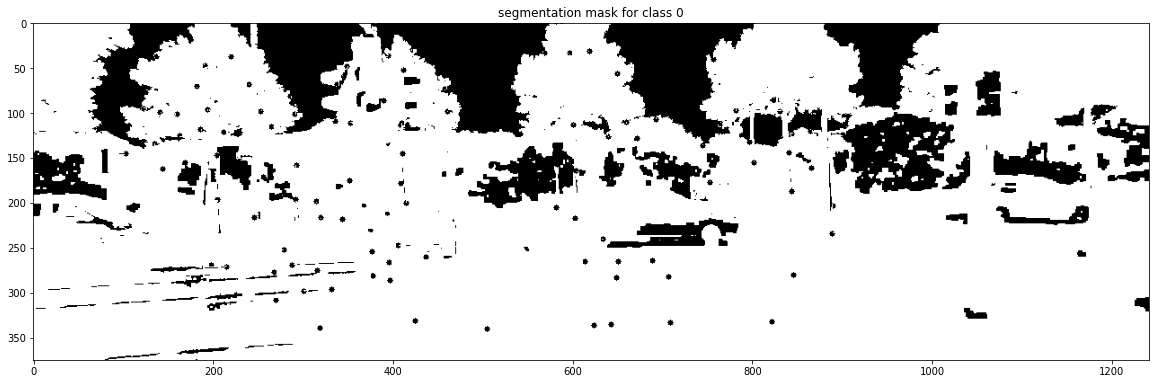

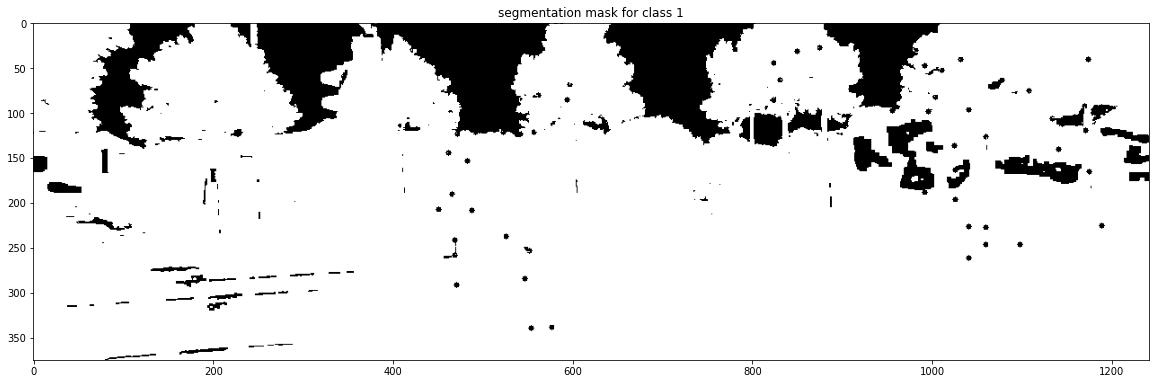

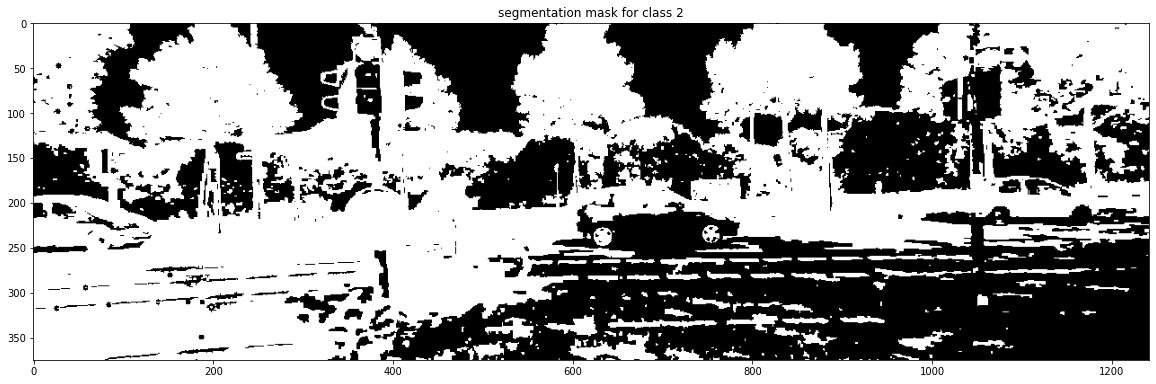

In [9]:
# assign outliers to class 0, and others to i+1, -1 is none_value
seed_mask_builder_left = MaskBuilder(imL.shape[0], imL.shape[1], MyGraphCuts.none_value)
for i in range(num_classes+1):
    class_pts = ptsL[np.where(E_ufl_models == i-1)]
    for pt in class_pts:
        seed_mask_builder_left.add_disk(pt[0], pt[1], 3, i)

# Get segmentation for different objects
seed_mask_left = seed_mask_builder_left.get_mask()
seg_diff_class_left = []
for i in range(1, num_classes+1):
    print("segmentation for class", i)
    print('------------')
    class_i_mask = np.full(seed_mask_left.shape, fill_value=MyGraphCuts.none_value)
    class_i_mask[np.where(seed_mask_left == i)] = MyGraphCuts.obj_value
    class_i_mask[np.where((seed_mask_left != MyGraphCuts.none_value) & (seed_mask_left != i))] = MyGraphCuts.bgr_value
    gc = MyGraphCuts(imL, sigma=0.5, lam=0.75)
    seg_i = gc.compute_labels(class_i_mask)
    seg_diff_class_left.append(seg_i)

# Show the result segmentation mask, note that black (0) represent the object, and white (1) is the background
for i in range(len(seg_diff_class_left)):
    seg = seg_diff_class_left[i]
    fig = plt.figure(14+i, figsize = (20, 8))
    axA = plt.subplot(111)
    axA.set_title(f"segmentation mask for class {i}")
    axA.imshow(seg)

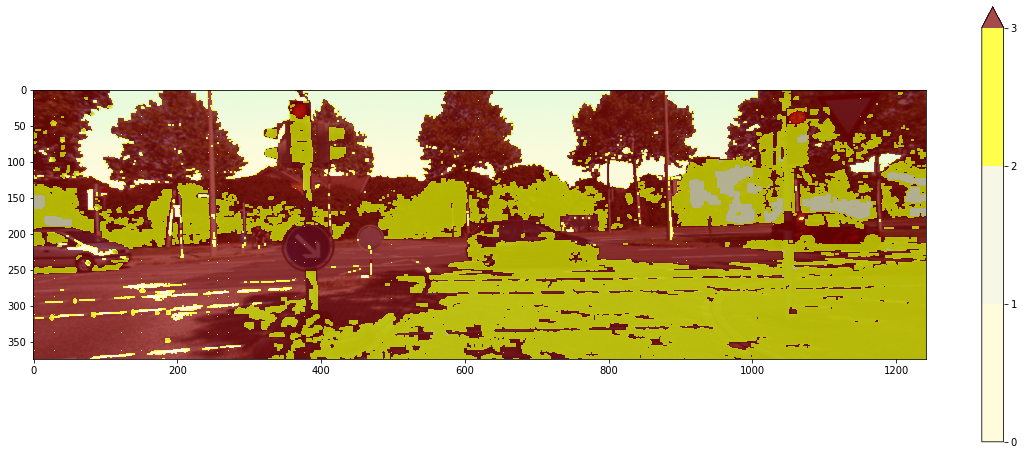

In [10]:
# Build the final segmentation by getting the mask for all objects
final_seg_left = np.full(seed_mask_left.shape, fill_value=MyGraphCuts.bgr_value)
for i in range(1, num_classes+1):
    seg_i = seg_diff_class_left[i-1]
    final_seg_left[np.where(seg_i == MyGraphCuts.obj_value)] = i

all_colors = list(cnames.keys())
colors = list(colorConverter.to_rgba_array(np.random.choice(all_colors, num_classes+1), 0.7))
fig,ax = plt.subplots(figsize=(20,8))
levels = range(len(colors))
cmap, norm = from_levels_and_colors(levels, colors, extend='max')
ax.imshow(imL)
mask_view = ax.imshow(final_seg_left, cmap=cmap, norm=norm)
fig.colorbar(mask_view)

segmentation for class 1
------------
segmentation for class 2
------------
segmentation for class 3
------------


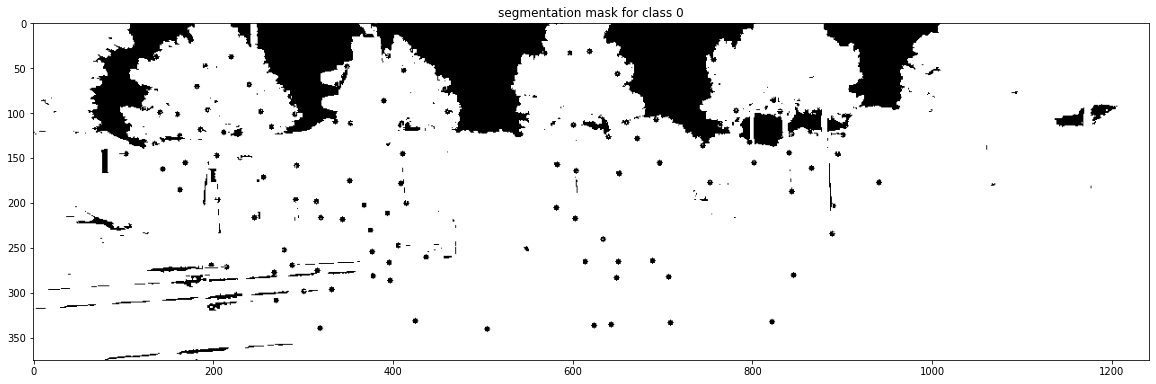

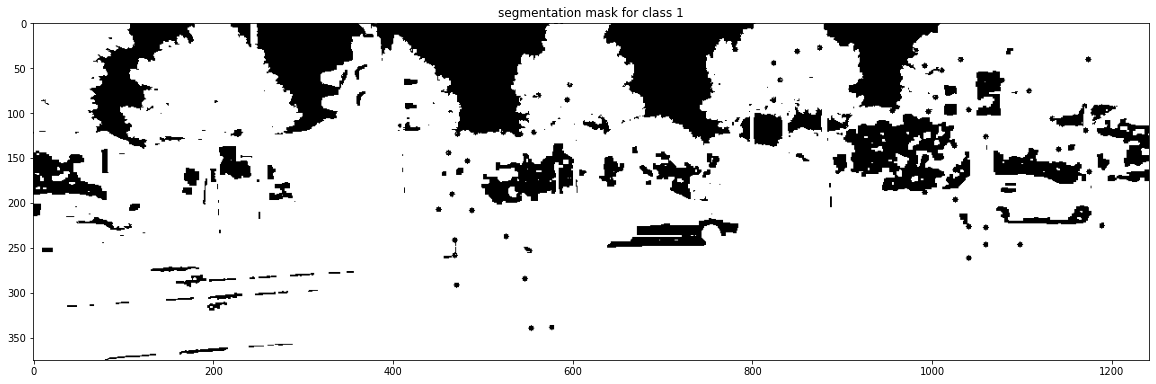

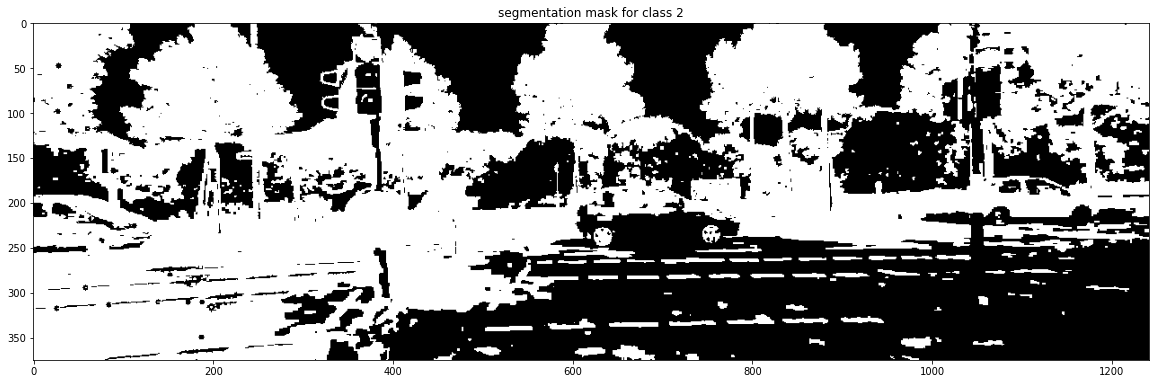

In [11]:
# assign outliers to class 0, and others to i+1, -1 is none_value
seed_mask_builder_right = MaskBuilder(imR.shape[0], imL.shape[1], MyGraphCuts.none_value)
for i in range(num_classes+1):
    class_pts = ptsL[np.where(E_ufl_models == i-1)]
    for pt in class_pts:
        seed_mask_builder_right.add_disk(pt[0], pt[1], 3, i)

# Get segmentation for different objects
seed_mask_right = seed_mask_builder_right.get_mask()
seg_diff_class_right = []
for i in range(1, num_classes+1):
    print("segmentation for class", i)
    print('------------')
    class_i_mask = np.full(seed_mask_right.shape, fill_value=MyGraphCuts.none_value)
    class_i_mask[np.where(seed_mask_right == i)] = MyGraphCuts.obj_value
    class_i_mask[np.where((seed_mask_right != MyGraphCuts.none_value) & (seed_mask_right != i))] = MyGraphCuts.bgr_value
    gc = MyGraphCuts(imL, sigma=0.5, lam=0.75)
    seg_i = gc.compute_labels(class_i_mask)
    seg_diff_class_right.append(seg_i)

# Show the result segmentation mask, note that black (0) represent the object, and white (1) is the background
for i in range(len(seg_diff_class_right)):
    seg = seg_diff_class_right[i]
    fig = plt.figure(14+i, figsize = (20, 8))
    axA = plt.subplot(111)
    axA.set_title(f"segmentation mask for class {i}")
    axA.imshow(seg)

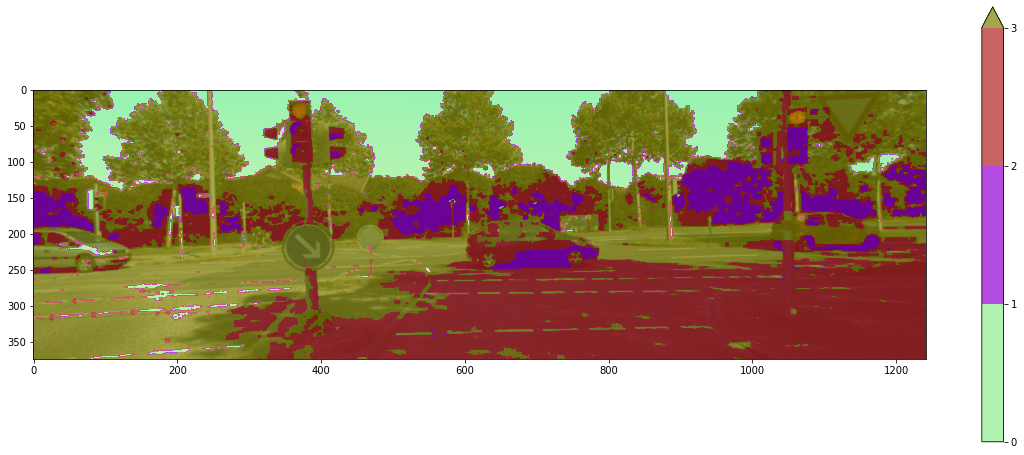

In [12]:
# Build the final segmentation by getting the mask for all objects
final_seg_right = np.full(seed_mask_right.shape, fill_value=MyGraphCuts.bgr_value)
for i in range(1, num_classes+1):
    seg_i = seg_diff_class_right[i-1]
    final_seg_right[np.where(seg_i == MyGraphCuts.obj_value)] = i

all_colors = list(cnames.keys())
colors = list(colorConverter.to_rgba_array(np.random.choice(all_colors, num_classes+1), 0.7))
fig,ax = plt.subplots(figsize=(20,8))
levels = range(len(colors))
cmap, norm = from_levels_and_colors(levels, colors, extend='max')
ax.imshow(imL)
mask_view = ax.imshow(final_seg_right, cmap=cmap, norm=norm)
fig.colorbar(mask_view)

## Conclusion

We see above that we can perform some level of segmentation on the two images without any user input: the trees are well-segmented and portions of the cars are segmented to a different class than the surrounding. However, there are a few areas of improvement that will produce better results.

We see that the main issue with our result is that UFL we have implemented is not as effective at categorizing. In an ideal implementation of UFL, we expect the points belonging to each car to be assigned to their own classes, and the points in the background to be all in a separate class. However, this was clearly not the case above: class 1 (purple class) includes both points from the car and points from the background. During testing, we found that the energy level of the computed model configuration in each iteration did not strictly decrease if left running until convergence. Thus we assume convergence when the energy level stops decreasing. This implies that we may not have found the optimal combination of models for the feature points. Furthermore, this observation indicates an inaccuracy with our UFL implementation, but due to time constraints, we were unable to completely find the cause of the problem. Hence, we have opted for perhaps an early stop for the algorithm, which means that the resulting models may contain redundant models, and the models might not be the most optimal.  

Another cause of issue is that there are not a lot of feature points for our objects, for example, the black car (that is in the shadow) only has two feature points, this makes it hard to categorize. Even if the points are all correctly categorized, it would be hard to perform segmentation given so little points. 

On the other hand, to improve the performance of graph cuts given better feature points, multi-terminal graph cuts can be used for the segmentation step [BVZ, PAMI 2001]. Since the iterated graph-cut approach only takes into account one class at a time, it could perform poorly for example when similar objects are overlapping on the image. However, with multi-terminal graph cuts, the algorithm will consider the whole image and the location of all classes, which will yield better result, especially in the case of overlapping objects.